In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import skeleton_plot as skpl
from skeleton_plot import skel_io

import caveclient
import cloudfiles

client = caveclient.CAVEclient('minnie65_phase3_v1')


C:\Users\clare.gamlin\AppData\Local\anaconda3\lib\site-packages\python_jsonschema_objects\__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [2]:
# function that takes a root id and then returns a dataframe will all the input synapses of that cell 
# with a column that is true/false, is apical

# cloud paths 
minnie_v661_mw_cloudpath = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/v661/meshworks'
# create a easy dictionary to search through the existing skeletons 
existing_skel_filenames = list(cloudfiles.CloudFiles(minnie_v661_mw_cloudpath))
rid_filename_dict = {int(fn.split('_')[0]):fn for fn in  existing_skel_filenames if '.h5' in fn}


# pull out the excitatory neuron table 
e_neuron_df = client.materialize.query_table('aibs_metamodel_celltypes_v661')

In [16]:
# start with an example neuron 
# pre_root_id = 864691135308347974
#MET-6 [864691135404765166, 864691135697251738, 864691136238652476, 864691136618564493, 864691136116457636]
#MET-8 = [864691135544588584, 864691135572082925, 864691135699487522]
#MET-4 didn't work 864691136118647832
#MET-4 = [864691135118298333, 864691135577202181, 864691135013417622, 864691135785592004, 864691135969447781, 864691136118647832 ]

pre_root_id =  864691136116457636

# # check out the excitatory postsynaptic partners of this neuron 
# postsyn_partners = client.materialize.synapse_query(pre_ids = [pre_root_id])
# e_rids = e_neuron_df[e_neuron_df['classification_system'] == 'excitatory_neuron']['pt_root_id'].values
# postsyn_e_partners = postsyn_partners[postsyn_partners['post_pt_root_id'].isin(e_rids)]

##create synapse table for older ids
from datetime import datetime, timezone
settime = datetime(2023, 9, 19, 4, 0, 0, 0, tzinfo=timezone.utc)
postsyn_partners_old = client.materialize.synapse_query(pre_ids = [pre_root_id], timestamp = settime)
print (postsyn_partners_old.shape)

# e_rids = e_neuron_df[e_neuron_df['classification_system'] == 'excitatory_neuron']['pt_root_id'].values
e_neuron_df = e_neuron_df.loc[(e_neuron_df['cell_type'] == '5P-IT')| (e_neuron_df['cell_type'] == '5P-ET')]
e_rids = e_neuron_df['pt_root_id'].values

postsyn_e_partners = postsyn_partners_old[postsyn_partners_old['post_pt_root_id'].isin(e_rids)]
print (postsyn_e_partners.head(30))



# we want to see which of these are excitatory cells and then look at the location 
# of that synapse on the postsynaptic cell to check if it is on the apical

# many cells in the dataset have skeletons that have apical labels 
# we will pull out the ones that do and then check if those synapses are on apicals
# the skeleton might not exist if there have been edits to the root id since dataset 661
# in that case, you can create that skeleton yourself and then run this analysis 
# that is covered in another notebook 


(1380, 12)
            id                          created  superceded_id valid   size  \
13   259226364 2020-11-04 06:49:46.278849+00:00            NaN     t   2276   
18   326936321 2020-11-04 06:51:43.367692+00:00            NaN     t   1500   
23   272992975 2020-11-04 06:53:26.207097+00:00            NaN     t    596   
26   253390061 2020-11-04 06:57:58.889833+00:00            NaN     t    280   
28   253389953 2020-11-04 06:57:58.889833+00:00            NaN     t    384   
32   286737398 2020-11-04 06:58:27.474011+00:00            NaN     t   1432   
33   348434200 2020-11-04 07:03:28.905689+00:00            NaN     t   2640   
36   286945539 2020-11-04 07:03:22.546382+00:00            NaN     t    272   
37   296212440 2020-11-04 07:03:46.531441+00:00            NaN     t   7872   
45   296212364 2020-11-04 07:03:46.531441+00:00            NaN     t  11416   
50   290298824 2020-11-04 07:09:03.516572+00:00            NaN     t   1056   
61   275535399 2020-11-04 07:15:06.069283

In [20]:
# let's take a look at the first postsynaptic excitatory cell
# we will also note the 'id' of the synapse so we can visualize it 

post_root_id = 864691135780790864
post_syn_id = 278764249


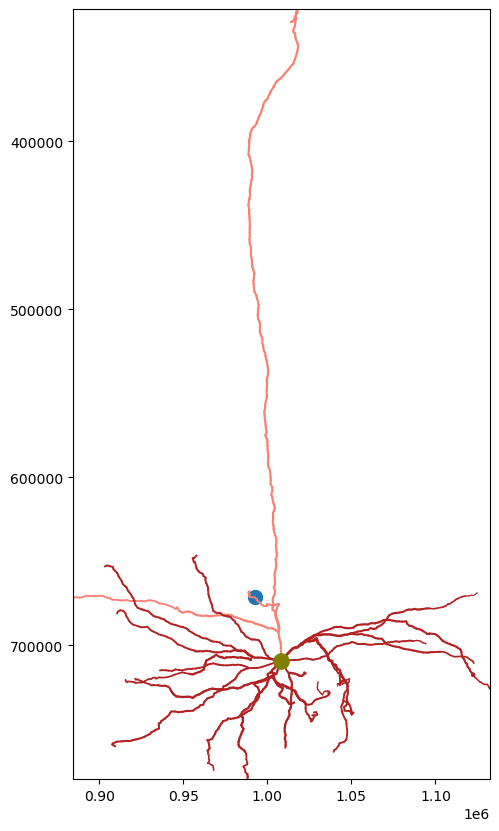

In [21]:
# some functions to help us along 
def check_if_syn_on_apical(mw, synapse_id):
    '''
    checks if a specific synapse on a given meshwork (mw) is on the apical node
    returns True or False
    
    '''
    # get the mesh index of the nrn at that synapse id
    syn_df = mw.anno.post_syn.df
    syn_mw_ind = syn_df[syn_df['id'] == synapse_id]['post_pt_mesh_ind_filt'].values
    
    return syn_mw_ind in mw.anno.apical_mesh_labels.df['mesh_index_filt'].values




def post_df_on_apical(pre_root_id, e_neuron_df = e_neuron_df, rid_filename_dict = rid_filename_dict,
                     mw_folder_path = minnie_v661_mw_cloudpath):
    
    '''
    takes a presynaptic neuron and gets all postsynaptic partners that are classified as excitatory 
    from those excitatory neurons, find the skeletons that already exist and print those numbers 
    
    '''
    # first get all postsynaptic partners 
    postsyn_partners = client.materialize.synapse_query(pre_ids = [pre_root_id])
    ##CG edit
    if postsyn_partners.empty:
        postsyn_partners = client.materialize.synapse_query(pre_ids = [pre_root_id], timestamp = settime)


    # can only classify apical on excitatory, so reduce this table to just 
    # the post partners belonging to excitatory cells
    e_neuron_df = e_neuron_df.loc[(e_neuron_df['cell_type'] == '5P-IT')| (e_neuron_df['cell_type'] == '5P-ET')]
    e_rids = L5_e_neuron_df['pt_root_id'].values

    #     e_rids = e_neuron_df[e_neuron_df['classification_system'] == 'excitatory_neuron']['pt_root_id'].values
    postsyn_e_partners = postsyn_partners[postsyn_partners['post_pt_root_id'].isin(e_rids)]
    
    
    # now check how many of these already have a skeleton stored in the cloud
    already_have = set(postsyn_e_partners['post_pt_root_id'])&set(rid_filename_dict.keys())
    to_create = already_have ^ set(postsyn_e_partners['post_pt_root_id'])
    
    print(f'{len(already_have)} postsynaptic excitatory skeletons already exist, {len(to_create)} must be created.')
        
    # create the dictionary from which to store if the synapse id is onto an apical dendrite 
    synapse_id_apical_dict = {}
    
    syn_ids = postsyn_e_partners[postsyn_e_partners['post_pt_root_id'].isin(already_have)]['id']
    syn_ids_rid_dict = postsyn_e_partners[['id', 'post_pt_root_id']].set_index('id').to_dict()['post_pt_root_id']
    
    for syn_id in syn_ids:
        rid = syn_ids_rid_dict[syn_id]
        print(f'working on postsynaptic neuron {rid} on synapse id {syn_id}')
        fn = rid_filename_dict[rid]
        mw = skel_io.load_mw(mw_folder_path, fn)
        
        # figure out if this synapse is on an apical
        is_on_apical = check_if_syn_on_apical(mw, syn_id)
        
        synapse_id_apical_dict[syn_id] = is_on_apical
        
    
    return synapse_id_apical_dict
    
    

# function to double check if a synapse is on the apical of a neuron (apical is pink)
def plot_synapse_id_on_mw(mw, syn_id, synapse_plot_size = 100, figsize=(7,10), pull_compartment_colors=True, pull_radius=True, line_width=5, 
                          plot_soma=True, invert_y=True):
    f , ax = plt.subplots(figsize=figsize)
    skpl.plot_tools.plot_mw_skel(mw, pull_compartment_colors=pull_compartment_colors, pull_radius=pull_radius, 
                                 line_width=line_width, plot_soma=plot_soma, invert_y=invert_y)
    
    syn_df = mw.anno.post_syn.df
    syn_mw_ind = syn_df[syn_df['id'] == syn_id]['post_pt_mesh_ind_filt'].values[0]
    syn_loc = mw.vertices[syn_mw_ind]

    plt.scatter(syn_loc[0], syn_loc[1], s = synapse_plot_size)
    


def load_cloud_mw_from_rid(rid, cloudpath = minnie_v661_mw_cloudpath):
    try:
        fn = rid_filename_dict[rid]
    except:
        print('a skeleton meshwork does not exist for this root id in the cloud. try another one')
    
    # load mw 
    mw = skel_io.load_mw(cloudpath, fn)
    return mw
    
    
# let's visualize that first postsynaptic excitatory cell synapse now 
# first, load the meshwork 
# post_root_id = 864691136039810558
# post_syn_id = 67080509
post_mw = load_cloud_mw_from_rid(post_root_id)
plot_synapse_id_on_mw(post_mw, post_syn_id)



In [22]:
# we can see this synapse is on the apical
# check that the function I wrote works, should return True 
check_if_syn_on_apical(post_mw, post_syn_id)


True

In [418]:
# now run this on all downstream cells
post_partner_is_apical = post_df_on_apical(pre_root_id)

177 postsynaptic excitatory skeletons already exist, 4 must be created.
working on postsynaptic neuron 864691135013420694 on synapse id 259226364
working on postsynaptic neuron 864691135307684422 on synapse id 326936321
working on postsynaptic neuron 864691135946705505 on synapse id 272992975
working on postsynaptic neuron 864691135864759004 on synapse id 253390061
working on postsynaptic neuron 864691135864759004 on synapse id 253389953
working on postsynaptic neuron 864691136237481999 on synapse id 286737398
working on postsynaptic neuron 864691135518377866 on synapse id 348434200
working on postsynaptic neuron 864691135937969461 on synapse id 286945539
working on postsynaptic neuron 864691136974547228 on synapse id 296212440
working on postsynaptic neuron 864691136974547228 on synapse id 296212364
working on postsynaptic neuron 864691136195279336 on synapse id 290298824
working on postsynaptic neuron 864691136066300312 on synapse id 275535399
working on postsynaptic neuron 864691136

working on postsynaptic neuron 864691135404562670 on synapse id 262178327
working on postsynaptic neuron 864691136237481999 on synapse id 275294295
working on postsynaptic neuron 864691135726417471 on synapse id 296279000
working on postsynaptic neuron 864691136135527051 on synapse id 285634904
working on postsynaptic neuron 864691136209976508 on synapse id 268871084
working on postsynaptic neuron 864691135683626994 on synapse id 286794094
working on postsynaptic neuron 864691135776954029 on synapse id 341441512
working on postsynaptic neuron 864691135279099809 on synapse id 263406424
working on postsynaptic neuron 864691135279099809 on synapse id 274868580
working on postsynaptic neuron 864691134885139194 on synapse id 234434816
working on postsynaptic neuron 864691135211093184 on synapse id 272381305
working on postsynaptic neuron 864691136663200222 on synapse id 282845892
working on postsynaptic neuron 864691135407470537 on synapse id 269462567
working on postsynaptic neuron 8646911

working on postsynaptic neuron 864691135182508802 on synapse id 290298851
working on postsynaptic neuron 864691135182508802 on synapse id 290410437
working on postsynaptic neuron 864691135479045574 on synapse id 279469173
working on postsynaptic neuron 864691135565518167 on synapse id 280033116
working on postsynaptic neuron 864691136618136539 on synapse id 248506590
working on postsynaptic neuron 864691136903972018 on synapse id 244266033
working on postsynaptic neuron 864691135446522514 on synapse id 259941172
working on postsynaptic neuron 864691135454926954 on synapse id 299965768
working on postsynaptic neuron 864691135937953077 on synapse id 266809726
working on postsynaptic neuron 864691136487855634 on synapse id 283135049
working on postsynaptic neuron 864691135585875836 on synapse id 244957759
working on postsynaptic neuron 864691135937953077 on synapse id 272941293
working on postsynaptic neuron 864691135123043111 on synapse id 253390916
working on postsynaptic neuron 8646911

working on postsynaptic neuron 864691135256856239 on synapse id 259898089
working on postsynaptic neuron 864691135256856239 on synapse id 257744095


In [419]:
# now run this on all downstream cells 
# post_partner_is_apical = post_df_on_apical(pre_root_id)

In [420]:
# here is a dictionary that tells you which post neurons are on apicals vs not 
post_partner_is_apical

{259226364: False,
 326936321: False,
 272992975: False,
 253390061: False,
 253389953: False,
 286737398: False,
 348434200: False,
 286945539: False,
 296212440: False,
 296212364: False,
 290298824: False,
 275535399: False,
 286790607: False,
 307559281: False,
 248147950: False,
 296666002: False,
 320731788: False,
 269087421: False,
 297092742: False,
 276848531: True,
 296219631: False,
 297036966: False,
 289521046: False,
 244264625: True,
 259898227: True,
 286738078: False,
 299817032: False,
 278764249: True,
 293315402: False,
 283160531: True,
 272381221: False,
 286659636: False,
 280429985: True,
 280430674: True,
 269484019: False,
 277380263: True,
 348458315: False,
 348458366: False,
 286372606: False,
 293422849: False,
 269087027: False,
 259279677: True,
 249126284: False,
 263849147: True,
 274414565: True,
 266116366: False,
 276559597: True,
 267132015: False,
 248929848: False,
 266057293: False,
 249126507: False,
 299748043: True,
 279860455: False,
 30125

In [421]:
# now you could apply that to the original df that lists all postsynaptic excitatory partners

postsyn_e_partners.head()

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
13,259226364,2020-11-04 06:49:46.278849+00:00,NaN,t,2276,97127147353026270,864691136116457636,97127078633528432,864691135013420694,"[235366, 196892, 22847]","[235354, 196792, 22848]","[235410, 196840, 22849]"
18,326936321,2020-11-04 06:51:43.367692+00:00,NaN,t,1500,102687171630646360,864691136116457636,102757540374817126,864691135307684422,"[275988, 203582, 24052]","[276092, 203630, 24043]","[276040, 203576, 24043]"
23,272992975,2020-11-04 06:53:26.207097+00:00,NaN,t,596,98395022034506129,864691136116457636,98395022034521827,864691135946705505,"[244678, 206252, 25580]","[244768, 206304, 25594]","[244728, 206250, 25578]"
26,253390061,2020-11-04 06:57:58.889833+00:00,NaN,t,280,96636421770787650,864691136116457636,96636421770779120,864691135864759004,"[231664, 211092, 24204]","[231694, 211042, 24201]","[231636, 211070, 24204]"
28,253389953,2020-11-04 06:57:58.889833+00:00,NaN,t,384,96636421770774812,864691136116457636,96636421770773250,864691135864759004,"[231522, 210908, 24196]","[231522, 210946, 24188]","[231478, 210922, 24190]"


In [422]:
postsyn_e_partners['on_apical'] = postsyn_e_partners['id'].map(post_partner_is_apical)

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_7028\6627022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postsyn_e_partners['on_apical'] = postsyn_e_partners['id'].map(post_partner_is_apical)


In [423]:

postsyn_e_partners
postsyn_e_partners.to_csv('{}_postsyn_e_L5_partners.csv'.format(pre_root_id))

In [424]:
print(postsyn_e_partners['on_apical'].value_counts(normalize = True)) 
print(postsyn_e_partners['on_apical'].value_counts(dropna = False)) 


False    0.631737
True     0.368263
Name: on_apical, dtype: float64
False    211
True     123
NaN        9
Name: on_apical, dtype: int64


In [484]:
fname = '864691136118647832_postsyn_e_L5_partners.csv'
postsyn_e_targets = pd.read_csv(fname)
grouped = postsyn_e_targets.groupby(['post_pt_root_id']).count().reset_index()
# print (grouped.head())

multi_cxn = grouped[grouped["on_apical"] > 1]
multcxn_id = multi_cxn['post_pt_root_id'].values
# print (multi_cxn.head())
multcxn_id_partners = postsyn_e_targets[postsyn_e_targets['post_pt_root_id'].isin(multcxn_id)]
# print (multcxn_id_partners.head())
mgrouped = multcxn_id_partners.groupby(["post_pt_root_id", "on_apical"]).count().reset_index()
# print (mgrouped.head())

mgrouped['duplicated'] = mgrouped.duplicated(subset=['post_pt_root_id'], keep = False)
mgrouped_not_dup = mgrouped.loc[mgrouped['duplicated'] == False]
mgrouped_not_dup['syn_loc'] = mgrouped_not_dup['on_apical'].copy()

mgrouped_dup = mgrouped.loc[mgrouped['duplicated'] == True].drop_duplicates(subset = ['post_pt_root_id'] )
mgrouped_dup['syn_loc'] = 'Both'
mgrouped_append = mgrouped_dup.append(mgrouped_not_dup)

print (mgrouped_append.groupby(["syn_loc"]).count())

single_cxn = grouped[grouped["on_apical"] == 1]
single_cxn = single_cxn['post_pt_root_id'].values
# print (multi_cxn.head())
single_cxn_id_partners = postsyn_e_targets[postsyn_e_targets['post_pt_root_id'].isin(single_cxn)]
print (single_cxn_id_partners.groupby(["on_apical"]).count())

         post_pt_root_id  on_apical  Unnamed: 0   id  created  superceded_id  \
syn_loc                                                                        
False                109        109         109  109      109            109   
True                  22         22          22   22       22             22   
Both                 109        109         109  109      109            109   

         valid  size  pre_pt_supervoxel_id  pre_pt_root_id  \
syn_loc                                                      
False      109   109                   109             109   
True        22    22                    22              22   
Both       109   109                   109             109   

         post_pt_supervoxel_id  pre_pt_position  post_pt_position  \
syn_loc                                                             
False                      109              109               109   
True                        22               22                22   
Both        

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_7028\918958510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mgrouped_not_dup['syn_loc'] = mgrouped_not_dup['on_apical'].copy()
